In [2]:
from urllib.request import urlopen, Request
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from urllib.request import urlopen
from matplotlib import pyplot as plt
import math
import datetime
from time import sleep
import copy
import json
import sys
import csv
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr   
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.utils import shuffle
from statsmodels.stats.stattools import durbin_watson

In [231]:
def AutocorrelationTest(array):
    return durbin_watson(array)

def ReduceDates(dates):
    count = 0
    for date in dates:
        if count%5 != 0:
            dates[count] = ' '
        count += 1
    return dates        

def PlotColumn(df, columns, scaler = StandardScaler(), title=None, ylabel = None, xlabel = None):
    
    #color=np.random.rand(3,), label=column
    
    dff = df[columns].copy()
    dff['date'] = df['date']
    ax = plt.gca()
    ax.locator_params(nbins=40, axis='x')
    
    for column in columns:
        data = df[[column]]
        if scaler is not None:
            dff[column] = scaler.fit_transform(df[[column]])
       
        dff.plot(kind='line',x='date',y=column,ax=ax, figsize=(20,10),label=column)
        
        plt.xticks(rotation='80')
        plt.ylabel(ylabel, fontsize=25)
        plt.xlabel(xlabel, fontsize=25)
        plt.legend()
        plt.title(title, fontsize=40)
    
    del dff['date']
    return dff

def PlotCorrelationMatrix(dff, fontsize = 20):
    f = plt.figure(figsize=(20, 10))
    data = dff.corr();
    plt.matshow(data, fignum=f.number)
    
    for (i, j), z in np.ndenumerate(data):
        plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=fontsize, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.xticks(range(dff.shape[1]), dff.columns, fontsize=14, rotation=90)
    plt.yticks(range(dff.shape[1]), dff.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #plt.title('Correlation Matrix', fontsize=16);
    
def Predict(df, scaler = None, classifier = RandomForestClassifier(n_estimators=101, random_state=0), columns = None):
    print(df.shape)
    df.drop(df.tail(7).index,inplace=True) #missing data from news
    
    if columns is None:
        df = df.drop(['date','target_price', 'd_target_price'], axis = 1) # delete non-numeric columns
    else:
        target = df['target_rise_fall']
        df = df[columns].copy()
        df['target_rise_fall'] = target
        
    X = df.loc[:, df.columns != 'target_rise_fall']
    y = df.loc[:, df.columns == 'target_rise_fall']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    X_train_r = X_train.copy()
    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    classifier.fit(X_train, y_train.values.ravel())
    y_pred = classifier.predict(X_test)
    print("---------------------Summary------------------")
    print(classification_report(y_test,y_pred))
    print("----------------Confusion_matrix--------------")
    print(confusion_matrix(y_test,y_pred))
    print("--------------------Accuracy------------------")
    print(accuracy_score(y_test, y_pred))
    return  classifier , X_train_r
    
def DefineThreeClasses(df):
    df['target_rise_fall'] = np.where((df.target > 100.00),'Rise',df.target_rise_fall)
    df['target_rise_fall'] = np.where((df.target <-100.00),'Fall',df.target_rise_fall)
    df['target_rise_fall'] = np.where(((df.target >=-100) & (df.target <=100)),'Stay',df.target_rise_fall)
    print('Rise'+ str(df[df.target_rise_fall == 'Rise'].shape[0]))
    print('Fall'+ str(df[df.target_rise_fall == 'Fall'].shape[0]))
    print('Stay'+ str(df[df.target_rise_fall == 'Stay'].shape[0]))
    return df
    

# SUMAR TWITTER DATA - Selekcia relevantných atribútov - pseudo výber


In [420]:
df = pd.read_csv("data.csv")
dff = df[['date','open_price', 'close_price','tweet_volume', 'nonzero_positive_tweet', 'sum_compound', 'nonzero_compound_tweet', 'total_trans_fees', 'miners_revenue', 'market_cap','market_volume', 'num_of_transaction', 'bitcoin_trends', 'cobalt_price', 'oil_price', 'amd_price', 'intel_price', 'nvidia_price']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = dff['target_price'] - dff['close_price']
dff['my_feature2'] = dff.tweet_volume * (df.avg_sum_positive-df.avg_sum_negative)
#differences features
##
dff['d_tweet_volume'] = np.abs(np.insert(np.diff(dff['tweet_volume']), 0, 0))
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  open_price  close_price  tweet_volume  nonzero_positive_tweet  \
1  2019-03-27     3984.24      4087.07         78592                   45076   
2  2019-03-28     4087.58      4069.11         78766                   45490   
3  2019-03-29     4068.30      4098.37         70494                   40216   
4  2019-03-30     4092.14      4106.66         71713                   42099   
5  2019-03-31     4105.46      4105.40         62468                   35900   

   sum_compound  nonzero_compound_tweet  total_trans_fees  miners_revenue  \
1    19160.4929                   41193                48         7663796   
2    17701.7706                   41168                47         7555049   
3    15623.1953                   35872                63         7747502   
4    14089.0469                   33713                54         7361068   
5    13557.6306                   31640                44         7323231   

     market_cap  ...  bitcoin_trends  cobalt_price  oil_price  amd_price  \
1  7.198785e+10  ...              19       30000.0      67.35      24.89   
2  7.167900e+10  ...              18       30000.0      66.08      25.60   
3  7.220209e+10  ...              18       30000.0      67.93      25.52   
4  7.235519e+10  ...              16       30000.0      67.93      25.52   
5  7.233938e+10  ...              15       30000.0      67.93      25.52   

   intel_price  nvidia_price  target_price  d_target_price  my_feature2  \
1        53.16        176.50       4069.11          -17.96     5542.038   
2        53.11        177.25       4098.37           29.26     5061.247   
3        53.70        179.56       4106.66            8.29     4607.642   
4        53.70        179.56       4105.40           -1.26     4212.702   
5        53.70        179.56       4158.18           52.78     4078.143   

   d_tweet_volume  
1            5957  
2             174  
3            8272  
4            1219  
5            9245  

[5 rows x 22 columns]

<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


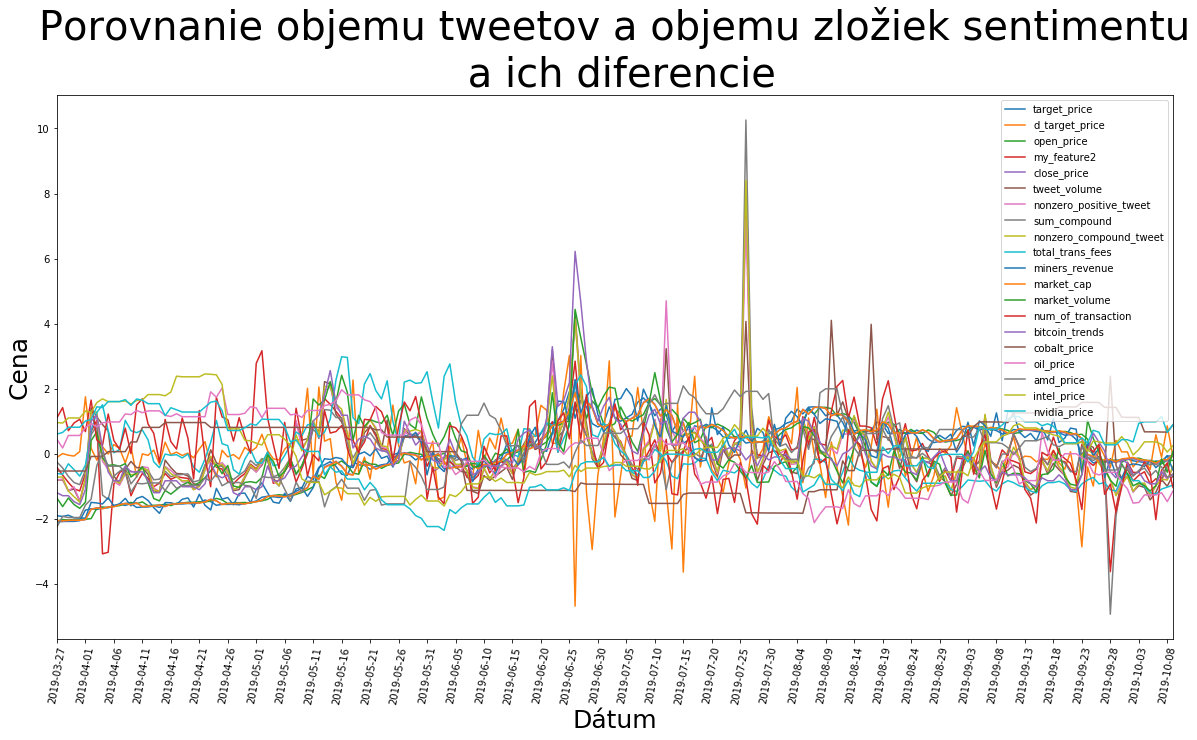

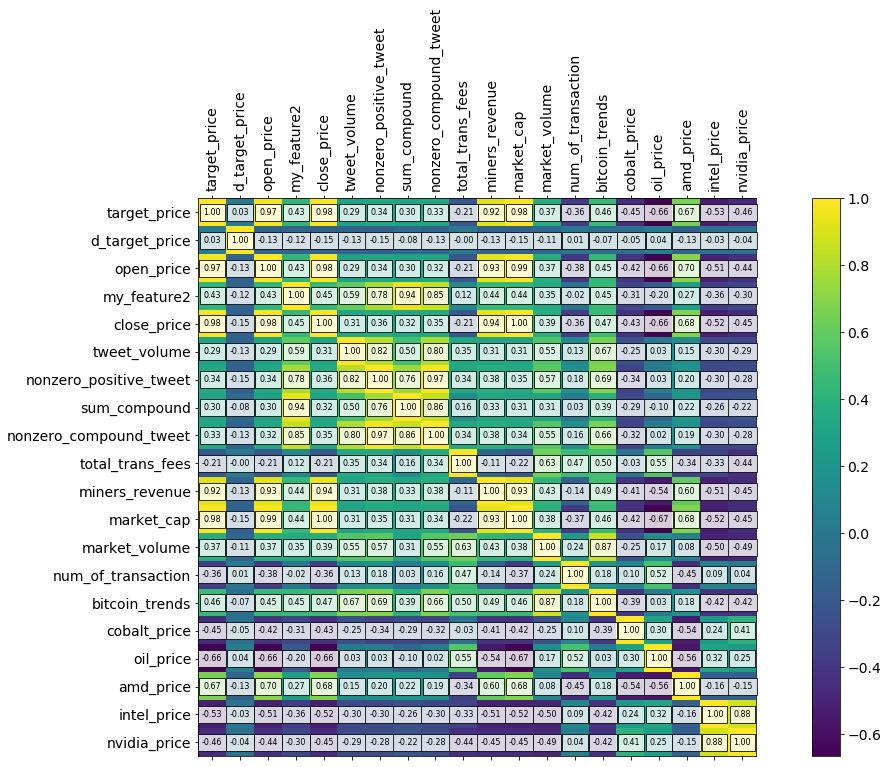

In [423]:
dfc = PlotColumn(dff, ['target_price','d_target_price','open_price','my_feature2', 'close_price','tweet_volume', 'nonzero_positive_tweet', 'sum_compound', 'nonzero_compound_tweet', 'total_trans_fees', 'miners_revenue', 'market_cap','market_volume', 'num_of_transaction', 'bitcoin_trends', 'cobalt_price', 'oil_price', 'amd_price', 'intel_price', 'nvidia_price'], scaler = StandardScaler(), title ='Porovnanie objemu tweetov a objemu zložiek sentimentu\n a ich diferencie',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc, fontsize = 8)
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

# SUMAR TWITTER DATA - úroveň jednotlivých častí sentimentu bez a so zohladnením počtu followerov


https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC  
 - SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, shrinking=True, probability=False, tol=0.001,    cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)  
 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier  
 - RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
 
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB
 - GaussianNB(priors=None, var_smoothing=1e-09)
 
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier  
 - KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)


In [507]:
def PrepareDataset():
    df = pd.read_csv("data.csv")
    dff = df[['date', 'open_price','close_price','tweet_volume', 'nonzero_positive_tweet', 'sum_compound', 'nonzero_compound_tweet', 'total_trans_fees', 'miners_revenue', 'market_cap','market_volume', 'num_of_transaction', 'bitcoin_trends', 'cobalt_price', 'oil_price', 'amd_price', 'intel_price', 'nvidia_price']].copy()
    dff['target_price'] = dff['close_price'].shift(-1) 
    dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
    #dff['d_price_move'] = dff.close_price - dff.open_price
    dff['d_tweet_volume'] = np.insert(np.diff(dff['tweet_volume']), 0, 0)  
    dff['my_feature2'] = dff.tweet_volume * (df.avg_sum_positive-df.avg_sum_negative)
    
    dff = dff[:-1]
    dff = dff.iloc[1:]
    dff['target_rise_fall'] = (dff.d_target_price>0.0)
    return dff

def GetColumnSet(choice = None):
    if choice == 'compound':
        ret = ['target_rise_fall', 'open_price','close_price','tweet_volume', 'nonzero_positive_tweet', 'total_trans_fees','sum_compound', 'miners_revenue', 'market_cap','market_volume', 'num_of_transaction', 'cobalt_price', 'oil_price', 'nvidia_price', 'my_feature2']
        msg = ret
    if choice == 'myfeatures':
        ret = ['tweet_volume', 'nonzero_positive_tweet', 'nonzero_compound_tweet', 'sum_positive', 'sum_compound', 'target_rise_fall','my_feature1','my_feature2','my_feature3','my_feature4',]
        msg = ret
    if choice is None:
        ret = None
        msg = 'ALL'
    print("Selected columns>> " + str(msg)+"\n\n")
    return ret

# Random Forrest whole set

In [508]:
###CLASSIFICATION###DONT MOVE PrepareDataset()  TO SEPARATE BLOCK  - DF must be initialized every time

dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = RandomForestClassifier(n_estimators=101), columns = GetColumnSet())
feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

Selected columns>> ALL


(197, 23)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.58      0.50      0.54        22
        True       0.62      0.69      0.65        26

    accuracy                           0.60        48
   macro avg       0.60      0.60      0.60        48
weighted avg       0.60      0.60      0.60        48

----------------Confusion_matrix--------------
[[11 11]
 [ 8 18]]
--------------------Accuracy------------------
0.6041666666666666


importance
close_price           0.072031
market_cap            0.068119
cobalt_price          0.066517
num_of_transaction    0.065728
amd_price             0.065656
total_trans_fees      0.062793
open_price            0.060092
miners_revenue        0.058799
nvidia_price          0.055759
d_tweet_volume        0.052052

In [509]:
###CLASSIFICATION###DONT MOVE PrepareDataset()  TO SEPARATE BLOCK  - DF must be initialized every time

dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = RandomForestClassifier(n_estimators=101), columns = GetColumnSet('compound'))
feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

Selected columns>> ['target_rise_fall', 'open_price', 'close_price', 'tweet_volume', 'nonzero_positive_tweet', 'total_trans_fees', 'sum_compound', 'miners_revenue', 'market_cap', 'market_volume', 'num_of_transaction', 'cobalt_price', 'oil_price', 'nvidia_price', 'my_feature2']


(197, 23)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.60      0.52      0.56        23
        True       0.61      0.68      0.64        25

    accuracy                           0.60        48
   macro avg       0.60      0.60      0.60        48
weighted avg       0.60      0.60      0.60        48

----------------Confusion_matrix--------------
[[12 11]
 [ 8 17]]
--------------------Accuracy------------------
0.6041666666666666


importance
num_of_transaction        0.113229
total_trans_fees          0.101071
nvidia_price              0.080786
oil_price                 0.075403
open_price                0.071253
market_volume             0.068000
tweet_volume              0.066867
my_feature2               0.063074
cobalt_price              0.062195
nonzero_positive_tweet    0.061743

# GaussianNB - whole dataset

In [510]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler() , classifier = GaussianNB(), columns = GetColumnSet())

Selected columns>> ALL


(197, 23)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.55      0.29      0.37        21
        True       0.59      0.81      0.69        27

    accuracy                           0.58        48
   macro avg       0.57      0.55      0.53        48
weighted avg       0.57      0.58      0.55        48

----------------Confusion_matrix--------------
[[ 6 15]
 [ 5 22]]
--------------------Accuracy------------------
0.5833333333333334


In [514]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler() , classifier = GaussianNB(), columns = GetColumnSet('compound'))

Selected columns>> ['target_rise_fall', 'open_price', 'close_price', 'tweet_volume', 'nonzero_positive_tweet', 'total_trans_fees', 'sum_compound', 'miners_revenue', 'market_cap', 'market_volume', 'num_of_transaction', 'cobalt_price', 'oil_price', 'nvidia_price', 'my_feature2']


(197, 23)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.33      0.14      0.20        21
        True       0.54      0.78      0.64        27

    accuracy                           0.50        48
   macro avg       0.44      0.46      0.42        48
weighted avg       0.45      0.50      0.45        48

----------------Confusion_matrix--------------
[[ 3 18]
 [ 6 21]]
--------------------Accuracy------------------
0.5


# SVM - whole dataset

Selected columns>> ALL


(197, 23)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.68      0.71      0.70        21
        True       0.77      0.74      0.75        27

    accuracy                           0.73        48
   macro avg       0.73      0.73      0.73        48
weighted avg       0.73      0.73      0.73        48

----------------Confusion_matrix--------------
[[15  6]
 [ 7 20]]
--------------------Accuracy------------------
0.7291666666666666


C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


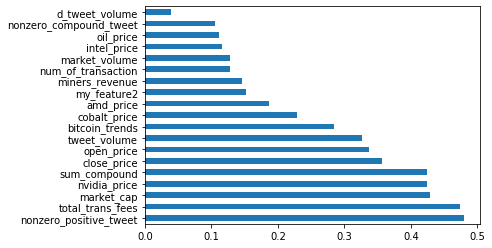

In [529]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK |
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = svm.LinearSVC(), columns = GetColumnSet())
pd.Series(abs(clf.coef_[0]), index=X_train.columns).nlargest(20).plot(kind='barh')

Selected columns>> ['target_rise_fall', 'open_price', 'close_price', 'tweet_volume', 'nonzero_positive_tweet', 'total_trans_fees', 'sum_compound', 'miners_revenue', 'market_cap', 'market_volume', 'num_of_transaction', 'cobalt_price', 'oil_price', 'nvidia_price', 'my_feature2']


(197, 23)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.65      0.46      0.54        28
        True       0.46      0.65      0.54        20

    accuracy                           0.54        48
   macro avg       0.56      0.56      0.54        48
weighted avg       0.57      0.54      0.54        48

----------------Confusion_matrix--------------
[[13 15]
 [ 7 13]]
--------------------Accuracy------------------
0.5416666666666666


C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


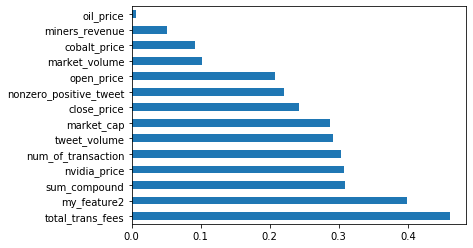

In [521]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK |
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = svm.LinearSVC(), columns = GetColumnSet('compound'))
pd.Series(abs(clf.coef_[0]), index=X_train.columns).nlargest(20).plot(kind='barh')

In [522]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK |
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = svm.SVC(gamma='scale'), columns = GetColumnSet())

Selected columns>> ALL


(197, 23)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.71      0.56      0.63        27
        True       0.56      0.71      0.63        21

    accuracy                           0.62        48
   macro avg       0.63      0.63      0.63        48
weighted avg       0.64      0.62      0.63        48

----------------Confusion_matrix--------------
[[15 12]
 [ 6 15]]
--------------------Accuracy------------------
0.625


In [525]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK |
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = svm.SVC(gamma='scale'), columns = GetColumnSet('compound'))

Selected columns>> ['target_rise_fall', 'open_price', 'close_price', 'tweet_volume', 'nonzero_positive_tweet', 'total_trans_fees', 'sum_compound', 'miners_revenue', 'market_cap', 'market_volume', 'num_of_transaction', 'cobalt_price', 'oil_price', 'nvidia_price', 'my_feature2']


(197, 23)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.73      0.39      0.51        28
        True       0.48      0.80      0.60        20

    accuracy                           0.56        48
   macro avg       0.61      0.60      0.56        48
weighted avg       0.63      0.56      0.55        48

----------------Confusion_matrix--------------
[[11 17]
 [ 4 16]]
--------------------Accuracy------------------
0.5625



# KNeighborsClassifier - whole dataset

In [526]:
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler() , classifier = KNeighborsClassifier(n_neighbors=5), columns = GetColumnSet())

Selected columns>> ALL


(197, 23)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.57      0.48      0.52        25
        True       0.52      0.61      0.56        23

    accuracy                           0.54        48
   macro avg       0.54      0.54      0.54        48
weighted avg       0.55      0.54      0.54        48

----------------Confusion_matrix--------------
[[12 13]
 [ 9 14]]
--------------------Accuracy------------------
0.5416666666666666


In [475]:
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler() , classifier = KNeighborsClassifier(n_neighbors=5), columns = GetColumnSet('myfeatures'))

Selected columns>> ['tweet_volume', 'nonzero_positive_tweet', 'nonzero_compound_tweet', 'sum_positive', 'sum_compound', 'target_rise_fall', 'my_feature1', 'my_feature2', 'my_feature3', 'my_feature4']


(197, 23)


KeyError: "['my_feature4', 'sum_positive', 'my_feature3', 'my_feature1'] not in index"

# Try for Votting classifiers

In [355]:
def Voting(df, columns = None, scaler = StandardScaler()):
    print(df.shape)
    df.drop(df.tail(7).index,inplace=True) #missing data from news
    
    if columns is None:
        df = df.drop(['date','target_price', 'd_target_price'], axis = 1) # delete non-numeric columns
    else:
        target = df['target_rise_fall']
        df = df[columns].copy()
        df['target_rise_fall'] = target
        
    X = df.loc[:, df.columns != 'target_rise_fall']
    y = df.loc[:, df.columns == 'target_rise_fall']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    X_train_r = X_train.copy()
    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    gnb = GaussianNB()
    rf = RandomForestClassifier(n_estimators=101)
    svml = svm.LinearSVC()
    svc = svm.SVC(gamma='scale')
    knb = KNeighborsClassifier(n_neighbors=5)
    
    gnb.fit(X_train, y_train.values.ravel())
    gnb_predict = gnb.predict(X_test)
    
    rf.fit(X_train, y_train.values.ravel())
    rf_predict = rf.predict(X_test)
    
    svml.fit(X_train, y_train.values.ravel())
    svm_predict = svml.predict(X_test)
    
    svc.fit(X_train, y_train.values.ravel())
    svc_predict = svc.predict(X_test)
    
    knb.fit(X_train, y_train.values.ravel())
    knb_predict = knb.predict(X_test)
    
    res = pd.DataFrame(gnb_predict, columns = ['gnb_predict']) 
    res['rf_predict'] = rf_predict
    res['svm_predict'] = svm_predict
    res['svc_predict'] = svc_predict
    res['knb_predict'] = knb_predict
    
    res['tftarget'] = np.array(y_test)
    return res

In [361]:
dff = PrepareDataset()
res = Voting(dff, columns = GetColumnSet('myfeatures'), scaler = StandardScaler())

Selected columns>> ['tweet_volume', 'nonzero_positive_tweet', 'nonzero_compound_tweet', 'sum_positive', 'sum_compound', 'target_rise_fall', 'my_feature1', 'my_feature2', 'my_feature3', 'my_feature4']


(197, 51)


C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [362]:
res.head(5)

gnb_predict  rf_predict  svm_predict  svc_predict  knb_predict  tftarget
0         True       False         True         True        False     False
1         True       False         True         True        False      True
2         True       False         True         True        False     False
3         True       False         True         True         True     False
4         True        True        False         True        False     False

In [363]:
for index, row in res.iterrows():
    count = 0
    if row['gnb_predict'] == True:
        count +=1
    if row['rf_predict'] == True:
        count +=1
    if row['svm_predict'] == True:
        count +=1
    if row['svc_predict'] == True:
        count +=1
    if row['knb_predict'] == True:
        count +=1
    if count >=3:
        res.set_value(index, 'vote_res', True)
        count = 0
        continue
    res.set_value(index, 'vote_res', False)
    count = 0
    

C:\Users\kriza\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\kriza\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [364]:
res.head(50)

gnb_predict  rf_predict  svm_predict  svc_predict  knb_predict  tftarget  \
0          True       False         True         True        False     False   
1          True       False         True         True        False      True   
2          True       False         True         True        False     False   
3          True       False         True         True         True     False   
4          True        True        False         True        False     False   
5          True        True         True         True         True      True   
6          True        True         True         True         True     False   
7          True        True         True         True         True      True   
8         False        True         True         True         True      True   
9         False       False         True         True        False     False   
10         True        True         True         True         True      True   
11         True        True         True         True         True      True   
12         True        True         True         True         True      True   
13         True       False        False         True        False      True   
14        False        True         True         True         True     False   
15         True       False         True         True        False     False   
16         True       False         True         True        False      True   
17         True       False         True         True        False      True   
18        False        True         True         True         True      True   
19        False        True        False         True        False     False   
20         True        True         True         True        False      True   
21         True        True         True         True         True      True   
22         True       False        False         True        False     False   
23         True       False         True         True        False     False   
24         True        True         True         True         True     False   
25         True        True        False         True         True     False   
26         True       False         True         True        False     False   
27         True        True         True         True         True      True   
28         True        True         True         True         True     False   
29         True        True         True         True         True      True   
30        False        True         True         True         True      True   
31        False        True         True         True        False     False   
32         True        True         True         True        False     False   
33         True        True         True         True        False      True   
34        False        True         True         True        False     False   
35         True       False         True         True        False      True   
36         True       False         True         True         True     False   
37        False       False        False        False        False     False   
38         True        True         True         True         True      True   
39        False        True         True         True         True      True   
40         True       False         True         True        False      True   
41         True        True         True         True        False      True   
42        False        True         True         True         True      True   
43         True       False         True         True        False     False   
44         True        True         True         True         True     False   
45         True       False         True         True         True      True   
46         True        True         True         True         True     False   
47         True       False         True         True         True     False   

   vote_res  
0      True  
1      True  
2      True  
3      True  
4      True  

In [365]:

print("---------------------Summary------------------")
print(classification_report(res.tftarget.values.tolist(), res.vote_res.values.tolist()))
print("----------------Confusion_matrix--------------")
print(confusion_matrix(res.tftarget.values.tolist(), res.vote_res.values.tolist()))
print("--------------------Accuracy------------------")
print(accuracy_score(res.tftarget.values.tolist(), res.vote_res.values.tolist()))

---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.80      0.17      0.28        24
        True       0.53      0.96      0.69        24

    accuracy                           0.56        48
   macro avg       0.67      0.56      0.48        48
weighted avg       0.67      0.56      0.48        48

----------------Confusion_matrix--------------
[[ 4 20]
 [ 1 23]]
--------------------Accuracy------------------
0.5625
